#Loading libraries and dataset

In [ ]:
#necessary package
import re
import pickle
import numpy as np
import pandas as pd
import spacy

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# nltk
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn import pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, log_loss, make_scorer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

#wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#load data from kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#Upload Kaggle API json file to Google Colab
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

#select data
!kaggle datasets download -d kazanova/sentiment140

 87% 70.0M/80.9M [00:03<00:00, 12.7MB/s]
100% 80.9M/80.9M [00:03<00:00, 24.4MB/s]


In [ ]:
#import dataset
Col  = ["sentiment", "ids", "date", "flag", "user", "text"]
data = pd.read_csv('sentiment140.zip', compression='zip', header=0, sep=',', quotechar='"', encoding="ISO-8859-1", names=Col)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   ids        1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   flag       1599999 non-null  object
 4   user       1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#Text Preprocessing and EDA

In [ ]:
#drop unnecessary feature
data = data.drop(['ids', 'date', 'flag', 'user'], axis=1)

#Sentiment adjustment
lab_to_sentiment = {0:'Negative', 4:'Positive'}
def label_decoder(label):
  return lab_to_sentiment[label]
data.sentiment = data.sentiment.apply(lambda x: label_decoder(x))

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

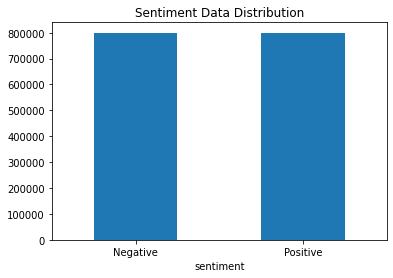

In [ ]:
# Replacing the values to ease understanding.
data['sentiment'] = data['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Sentiment Data Distribution',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)


In [ ]:
%%time
#Clean text
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@ \S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 1.57 ms


In [ ]:
#text preparing
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
%%time
data.text = data.text.apply(lambda x: preprocess(x))

CPU times: user 42.2 s, sys: 107 ms, total: 42.3 s
Wall time: 42.3 s


In [ ]:
data.head()

,sentiment,text
0,Negative,upset update facebook texting might cry result...
1,Negative,kenichan dived many times ball managed save 50...
2,Negative,whole body feels itchy like fire
3,Negative,nationwideclass behaving mad see
4,Negative,kwesidei whole crew


CPU times: user 47.8 s, sys: 1.26 s, total: 49.1 s
Wall time: 49.3 s


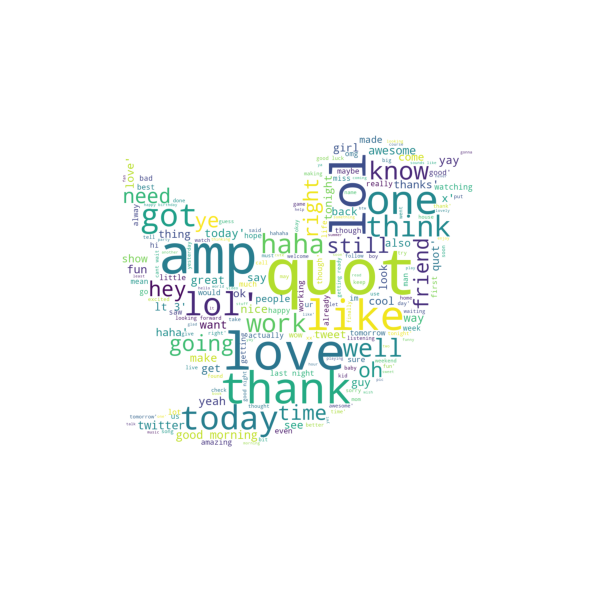

In [ ]:
%%time
text = str(data[data.sentiment == 'Positive'].text.tolist())
mask = np.array(Image.open(requests.get('https://www.lter-europe.net/document-archive/image-gallery/albums/logos/TwitterLogo_55acee.png/image', stream=True).raw))


# Write a function takes in text and mask and generates a wordcloud. 
def generate_wordcloud(mask):
  word_cloud = WordCloud( background_color='white', stopwords=stop_words, mask=mask)
  word_cloud.generate(text)
  plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.tight_layout(pad=0)

#Run the following to generate wordcloud
generate_wordcloud(mask)

CPU times: user 50.6 s, sys: 882 ms, total: 51.4 s
Wall time: 51.7 s


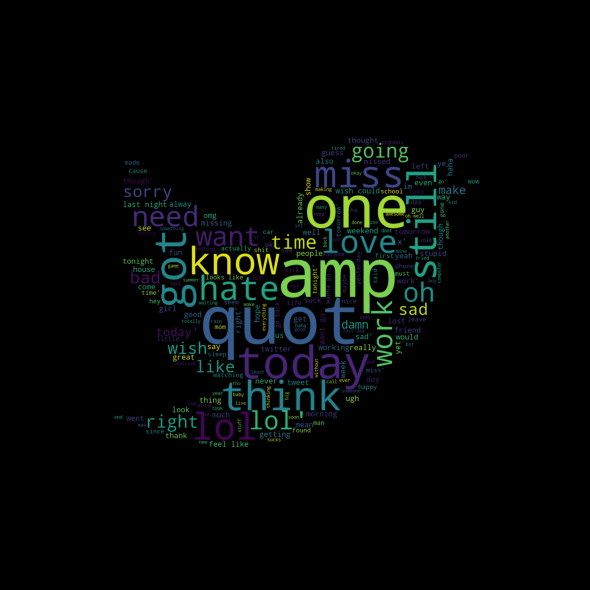

In [ ]:
%%time
text = str(data[data.sentiment == 'Negative'].text.tolist())
mask = np.array(Image.open(requests.get('https://www.lter-europe.net/document-archive/image-gallery/albums/logos/TwitterLogo_55acee.png/image', stream=True).raw))


# Write a function takes in text and mask and generates a wordcloud. 
def generate_wordcloud(mask):
  word_cloud = WordCloud( background_color='black', stopwords=stop_words, mask=mask)
  word_cloud.generate(text)
  plt.figure(figsize=(10,8),facecolor = 'black', edgecolor='blue')
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.tight_layout(pad=0)

#Run the following to generate wordcloud
generate_wordcloud(mask)

# Helpful function

In [ ]:
#tranfer sentiment to interger
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment)

In [ ]:
#Lets's try to extract components via TruncatedSVD
#100-200 component are good enough for running model
svd = TruncatedSVD(n_components=140) #I chose 140

#BoW

## Feature Engineering

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(data['text'])
print('No. of feature_words: ', len(count_vectorizer.get_feature_names()))

No. of feature_words:  593859


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cv, y,
                                                    test_size = 0.1, random_state = 0)

In [ ]:
%%time
#fit svd into X_train
svd.fit(X_train)

## Transform x
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

CPU times: user 3min 35s, sys: 40.2 s, total: 4min 16s
Wall time: 1min 52s


In [ ]:
print(X_train.shape)
print(X_train_svd.shape)
print(y_train.shape)

(1439999, 593859)
(1439999, 140)
(1439999,)


In [ ]:
def model_Evaluate(model):    
  # Predict values for Test dataset
  y_pred = model.predict(X_test_svd)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':16}, pad = 20)

## Modeling

### BernoulliNB

In [ ]:
%%time
#testing how fit of the dataset
BNBmodel_bow = BernoulliNB(alpha = 2)
BNBmodel_bow.fit(X_train_svd, y_train)
print("----------------------Naive Bayes Scores----------------------")
print('Training set score:', BNBmodel_bow.score(X_train_svd, y_train))
print('Tesing set score:', BNBmodel_bow.score(X_test_svd, y_test))

----------------------Naive Bayes Scores----------------------
Training set score: 0.6190837632526134
Tesing set score: 0.6194625
CPU times: user 9 s, sys: 846 ms, total: 9.85 s
Wall time: 7.81 s


In [ ]:
%%time
#making prediction
predictions_bnb_bow = BNBmodel_bow.predict_proba(X_train_svd)

#log loss
logloss_bow_bnb = log_loss(y_train, predictions_bnb_bow)

print ("logloss:  {:.3f}".format(logloss_bow_bnb))

#accuracy score
BNBmodel_bow_score = BNBmodel_bow.score(X_test_svd, y_test)

logloss:  0.683
CPU times: user 4.6 s, sys: 644 ms, total: 5.25 s
Wall time: 4.06 s


              precision    recall  f1-score   support

           0       0.62      0.60      0.61     80048
           1       0.62      0.64      0.63     79952

    accuracy                           0.62    160000
   macro avg       0.62      0.62      0.62    160000
weighted avg       0.62      0.62      0.62    160000

CPU times: user 870 ms, sys: 550 ms, total: 1.42 s
Wall time: 768 ms


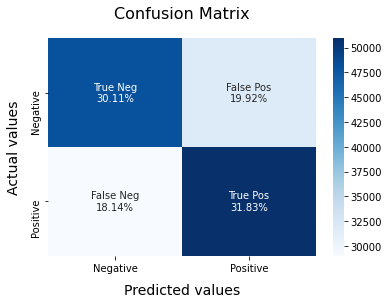

In [ ]:
#model evaluation
%%time
model_Evaluate(BNBmodel_bow)

### Logistic Regression

In [ ]:
%%time
#testing how fit of the dataset
lr_bow = LogisticRegression()
lr_bow.fit(X_train_svd, y_train)

#testing overfiting
print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr_bow.score(X_train_svd, y_train))
print('Tesing set score:', lr_bow.score(X_test_svd, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.6906643685169226
Tesing set score: 0.69035625
CPU times: user 30 s, sys: 12.9 s, total: 43 s
Wall time: 12 s


In [ ]:
%%time
#making prediction
predictions_lr_bow = lr_bow.predict_proba(X_train_svd)

#log loss
logloss_bow_lr = log_loss(y_train, predictions_lr_bow)

print ("logloss:  {:.3f}".format(logloss_bow_lr))

#accuracy score
lr_bow_score = lr_bow.score(X_test_svd, y_test)

logloss:  0.584
CPU times: user 854 ms, sys: 606 ms, total: 1.46 s
Wall time: 629 ms


              precision    recall  f1-score   support

           0       0.71      0.63      0.67     80048
           1       0.67      0.75      0.71     79952

    accuracy                           0.69    160000
   macro avg       0.69      0.69      0.69    160000
weighted avg       0.69      0.69      0.69    160000

CPU times: user 619 ms, sys: 335 ms, total: 955 ms
Wall time: 570 ms


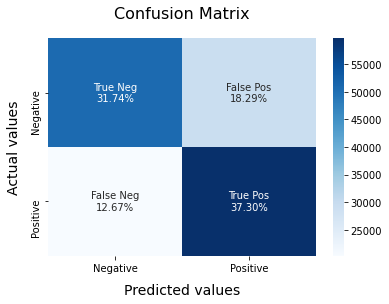

In [ ]:
#model evaluation
%%time
model_Evaluate(lr_bow)

### Random Forest

In [ ]:
%%time
#testing how fit of the dataset
rf_bow= RandomForestClassifier(criterion = 'entropy', max_features= 'log2', n_estimators=200, max_samples=0.5, max_depth=5) #max_features= sqrt or log and sub sample (max_sample)
rf_bow.fit(X_train_svd, y_train)
print("----------------------Random Forest Scores----------------------")
print('Training set score:', rf_bow.score(X_train_svd, y_train))
print('Tesing set score:', rf_bow.score(X_test_svd, y_test))

----------------------Random Forest Scores----------------------
Training set score: 0.6728789394992636
Tesing set score: 0.6712
CPU times: user 26min 36s, sys: 974 ms, total: 26min 37s
Wall time: 26min 38s


In [ ]:
%%time
#making prediction
predictions_rf_bow = rf_bow.predict_proba(X_train_svd)

#log loss
logloss_bow_rf = log_loss(y_train, predictions_rf_bow)

print ("logloss:  {:.3f}".format(logloss_bow_rf))

#accuracy score
rf_bow_score = rf_bow.score(X_test_svd, y_test)

logloss:  0.643
CPU times: user 33.9 s, sys: 63.1 ms, total: 34 s
Wall time: 34 s


              precision    recall  f1-score   support

           0       0.69      0.63      0.66     80048
           1       0.66      0.71      0.68     79952

    accuracy                           0.67    160000
   macro avg       0.67      0.67      0.67    160000
weighted avg       0.67      0.67      0.67    160000

CPU times: user 3.62 s, sys: 12 ms, total: 3.63 s
Wall time: 3.64 s


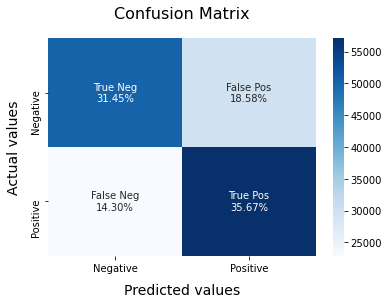

In [ ]:
#model evaluation
%%time
model_Evaluate(rf_bow)

### XGBoost

In [ ]:
%%time
#testing how fit of the dataset
xgb_bow = XGBClassifier(nthread=10 )
xgb_bow.fit(X_train_svd, y_train)
print("----------------------XGBClassifier Scores----------------------")
print('Training set score:', xgb_bow.score(X_train_svd, y_train))
print('Tesing set score:', xgb_bow.score(X_test_svd, y_test))

----------------------XGBClassifier Scores----------------------
Training set score: 0.6926247865449907
Tesing set score: 0.68974375
CPU times: user 45min 30s, sys: 1.81 s, total: 45min 32s
Wall time: 11min 35s


In [ ]:
%%time
#making prediction
predictions_xgb_bow = xgb_bow.predict_proba(X_train_svd)

#log loss
logloss_bow_xgb = log_loss(y_train, predictions_xgb_bow)

print ("logloss: {:.3f}".format(logloss_bow_xgb))

#accuracy score
xgb_bow_score = xgb_bow.score(X_test_svd, y_test)

logloss: 0.582
CPU times: user 9.28 s, sys: 20 ms, total: 9.3 s
Wall time: 3.49 s


              precision    recall  f1-score   support

           0       0.70      0.67      0.68     80048
           1       0.68      0.71      0.70     79952

    accuracy                           0.69    160000
   macro avg       0.69      0.69      0.69    160000
weighted avg       0.69      0.69      0.69    160000

CPU times: user 1.5 s, sys: 9.95 ms, total: 1.51 s
Wall time: 868 ms


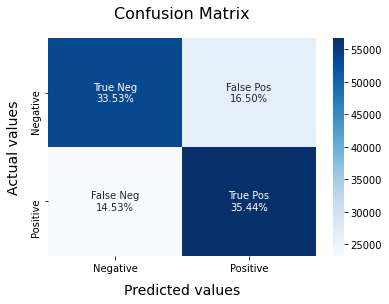

In [ ]:
#model evaluation
%%time
model_Evaluate(xgb_bow)

#Word2Vec

## Feature Engineering

In [ ]:
%%time
# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    data["text"],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1
)

CPU times: user 6min 40s, sys: 4.67 s, total: 6min 45s
Wall time: 2min 2s


In [ ]:
word2vec_arr = np.zeros((data.shape[0],100))

for i, sentence in enumerate(data["text"]):
    word2vec_arr[i,:] = np.mean([model[lemma] for lemma in sentence], axis=0)

word2vec_arr = pd.DataFrame(word2vec_arr)
data_w2v = pd.concat([data[["sentiment", "text"]],word2vec_arr], axis=1)
data_w2v.dropna(inplace=True)

data_w2v.head()

,sentiment,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,Negative,upset update facebook texting might cry result...,-0.264792,-0.091893,-0.045934,-0.082530,0.326875,0.031490,-0.097455,-0.291940,0.455286,0.554943,-0.105485,-0.062213,-0.267616,-0.361809,-0.181721,-0.158563,-0.033287,0.021665,0.143142,0.156176,0.334691,0.203411,0.002016,0.014577,-0.040989,-0.398219,0.122027,0.180282,0.154611,0.234864,0.171347,-0.031860,-0.686940,-0.013476,-0.014794,0.064527,0.210087,-0.061383,...,0.193965,0.051654,0.048097,0.081162,-0.206392,-0.361282,0.439858,-0.438877,-0.101439,0.388765,-0.171265,-0.063767,-0.099761,0.039506,0.128049,0.033267,-0.514960,0.283455,0.127950,-0.212978,-0.161953,0.363662,0.348803,0.075829,-0.025486,0.151051,0.340947,-0.132085,-0.160585,0.285390,0.354305,0.180032,-0.303534,0.229325,0.305676,0.014538,-0.014507,0.322219,0.130410,0.373812
1,Negative,kenichan dived many times ball managed save 50...,-0.200053,-0.027921,-0.057105,-0.081036,0.334559,0.012108,-0.101706,-0.272944,0.429298,0.540820,-0.103206,-0.096355,-0.228427,-0.272048,-0.172454,-0.178223,-0.112489,0.001243,0.199572,0.134621,0.353636,0.221763,-0.047304,-0.019093,-0.071618,-0.334561,0.167897,0.194358,0.149599,0.171044,0.061502,-0.127892,-0.495326,-0.006594,0.066091,0.134882,0.194978,-0.032708,...,0.226193,-0.002776,-0.045538,0.072290,-0.151437,-0.340573,0.391730,-0.412135,-0.145038,0.293046,-0.135797,-0.089856,0.007781,0.041304,0.116029,0.111305,-0.451729,0.348858,-0.075269,-0.138778,-0.252438,0.190541,0.364297,0.090841,-0.032344,0.176302,0.191116,-0.089372,-0.072544,0.294261,0.333560,0.124708,-0.297131,0.214410,0.287784,-0.069956,-0.038376,0.357270,0.233975,0.409757
2,Negative,whole body feels itchy like fire,-0.416170,-0.091854,-0.129390,-0.098099,0.378669,0.123456,-0.200828,-0.349705,0.417627,0.410443,-0.093565,-0.087469,-0.152364,-0.314952,-0.187043,-0.114938,-0.165128,0.015640,0.175211,0.131350,0.349453,0.158493,-0.021192,-0.026592,0.085797,-0.271899,0.172675,0.248637,0.081487,0.257154,0.124829,-0.081728,-0.664389,-0.015158,-0.001762,0.104515,0.248563,0.046244,...,0.134931,0.055767,0.073648,0.059236,-0.185891,-0.189585,0.419147,-0.390335,-0.102132,0.375491,-0.096150,-0.087645,-0.097583,0.228129,0.150710,0.066920,-0.444084,0.298970,0.116853,-0.190772,-0.170850,0.353311,0.362495,0.090125,0.044116,0.116927,0.431135,-0.214794,-0.095956,0.282565,0.379469,0.329790,-0.305346,0.236237,0.382805,-0.049812,0.102214,0.256183,0.188715,0.360984
3,Negative,nationwideclass behaving mad see,-0.231249,-0.125675,-0.066789,-0.056329,0.507983,0.119537,-0.231657,-0.321311,0.476842,0.543675,-0.100649,-0.099434,-0.102736,-0.240244,-0.128086,-0.187132,-0.179229,0.066048,0.180771,0.186358,0.426260,0.123891,-0.083843,-0.105499,0.013673,-0.379492,0.211129,0.226765,0.202079,0.215662,0.159406,-0.074909,-0.744415,0.043459,0.047770,0.234600,0.282546,-0.066893,...,0.322508,0.019881,-0.053527,0.155740,-0.227795,-0.369090,0.384489,-0.495817,-0.216723,0.338595,-0.079521,-0.124439,-0.039302,0.142845,0.110814,0.191592,-0.482742,0.307065,0.007521,-0.170143,-0.258379,0.229193,0.418105,0.125773,-0.038576,0.204746,0.271145,-0.093889,-0.090499,0.394954,0.375531,0.166979,-0.298060,0.173692,0.346366,-0.071742,0.056539,0.183918,0.172264,0.411951
4,Negative,kwesidei whole crew,-0.413360,-0.269344,-0.078263,-0.076943,0.578364,0.040831,-0.223611,-0.425764,0.524906,0.460702,-0.152256,0.018957,-0.155743,-0.264143,-0.097678,-0.149767,-0.231394,-0.036203,0.166008,0.277162,0.422101,0.099955,-0.059947,-0.161200,0.153373,-0.271167,0.151357,0.327783,0.122471,0.258885,0.107341,-0.061311,-0.800436,0.008544,-0.020241,0.140212,0.277203,0.083096,...,0.260120,0.121109,-0.031992,0.163428,-0.268376,-0.118995,0.402761,-0.420807,-0.252795,0.394167,-0.161666,-0.095010,-0.153118,0.304055,0.042326,-0.027344,-0.460715,0.347271,-0.057294,-

In [ ]:
Y = data_w2v['sentiment']
X = np.array(data_w2v.drop(['text','sentiment'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [ ]:
def model_Evaluate(model):    
  # Predict values for Test dataset
  y_pred = model.predict(X_test)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':16}, pad = 20)

## Modeling

### BernoulliNB

In [ ]:
%%time
#testing how fit of the dataset
BNBmodel_w2v = BernoulliNB(alpha = 2)
BNBmodel_w2v.fit(X_train, y_train)
print("----------------------Naive Bayes Scores----------------------")
print('Training set score:', BNBmodel_w2v.score(X_train, y_train))
print('Tesing set score:', BNBmodel_w2v.score(X_test, y_test))

----------------------Naive Bayes Scores----------------------
Training set score: 0.528103640750227
Tesing set score: 0.5265964763107549
CPU times: user 14 s, sys: 1.4 s, total: 15.4 s
Wall time: 13.4 s


In [ ]:
%%time
#making prediction
predictions_BNBmodel_w2v = BNBmodel_w2v.predict_proba(X_train)

#log loss
logloss_w2v_bnb = log_loss(y_train, predictions_BNBmodel_w2v)

print ("logloss:  {:.3f}".format(logloss_w2v_bnb))

#accuracy score
BNBmodel_w2v_score = BNBmodel_w2v.score(X_test, y_test)

logloss:  0.716
CPU times: user 7.86 s, sys: 661 ms, total: 8.52 s
Wall time: 7.42 s


              precision    recall  f1-score   support

    Negative       0.52      0.69      0.59     79872
    Positive       0.54      0.37      0.44     80074

    accuracy                           0.53    159946
   macro avg       0.53      0.53      0.51    159946
weighted avg       0.53      0.53      0.51    159946

CPU times: user 6.8 s, sys: 317 ms, total: 7.11 s
Wall time: 6.73 s


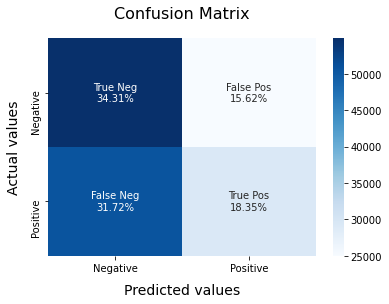

In [ ]:
#model evaluation
%%time
model_Evaluate(BNBmodel_w2v)

### Logistic Regression

In [ ]:
%%time
#testing how fit of the dataset
lr_w2v = LogisticRegression()
lr_w2v.fit(X_train, y_train)
print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr_w2v.score(X_train, y_train))
print('Tesing set score:', lr_w2v.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.5699310390820216
Tesing set score: 0.5684168406837308
CPU times: user 1min 33s, sys: 44.2 s, total: 2min 17s
Wall time: 43 s


In [ ]:
%%time
#making prediction
predictions_lr_w2v = lr_w2v.predict_proba(X_train)

#log loss
logloss_w2v_lr = log_loss(y_train, predictions_lr_w2v)

print ("logloss:  {:.3f}".format(logloss_w2v_lr))

#accuracy score
lr_w2v_score = lr_w2v.score(X_test, y_test)


logloss:  0.680
CPU times: user 5.71 s, sys: 617 ms, total: 6.32 s
Wall time: 5.48 s


              precision    recall  f1-score   support

    Negative       0.56      0.62      0.59     79872
    Positive       0.58      0.52      0.55     80074

    accuracy                           0.57    159946
   macro avg       0.57      0.57      0.57    159946
weighted avg       0.57      0.57      0.57    159946

CPU times: user 7.65 s, sys: 320 ms, total: 7.97 s
Wall time: 7.6 s


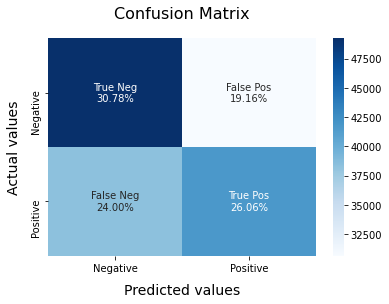

In [ ]:
#model evaluation
%%time
model_Evaluate(lr_w2v)

### Random Forest

In [ ]:
%%time
#testing how fit of the dataset
rf_w2v = RandomForestClassifier(criterion = 'entropy', max_features= 'log2', n_estimators=200, max_samples=0.5, max_depth=5)
rf_w2v.fit(X_train, y_train)
print("----------------------Random Forest Scores----------------------")
print('Training set score:', rf_w2v.score(X_train, y_train))
print('Tesing set score:', rf_w2v.score(X_test, y_test))

----------------------Random Forest Scores----------------------
Training set score: 0.570668789609805
Tesing set score: 0.5703424905905743
CPU times: user 24min 33s, sys: 293 ms, total: 24min 33s
Wall time: 24min 34s


In [ ]:
%%time
#making prediction
predictions_rf_w2v = rf_w2v.predict_proba(X_train)

#log loss
logloss_w2v_rf = log_loss(y_train, predictions_rf_w2v)

print ("logloss:  {:.3f}".format(logloss_w2v_rf))

#accuracy score
rf_w2v_score = rf_w2v.score(X_train, y_train)

logloss:  0.685
CPU times: user 57.8 s, sys: 78.8 ms, total: 57.9 s
Wall time: 57.9 s


              precision    recall  f1-score   support

    Negative       0.56      0.61      0.59     79872
    Positive       0.58      0.53      0.55     80074

    accuracy                           0.57    159946
   macro avg       0.57      0.57      0.57    159946
weighted avg       0.57      0.57      0.57    159946

CPU times: user 10.1 s, sys: 21 ms, total: 10.1 s
Wall time: 10.1 s


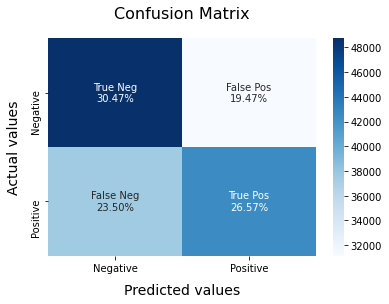

In [ ]:
#model evaluation
%%time
model_Evaluate(rf_w2v)

### XGBoost

In [ ]:
%%time
#testing how fit of the dataset
xgb_w2v = XGBClassifier()
xgb_w2v.fit(X_train, y_train)
print("----------------------XGBClassifier Scores----------------------")
print('Training set score:', xgb_w2v.score(X_train, y_train))
print('Tesing set score:', xgb_w2v.score(X_test, y_test))

----------------------XGBClassifier Scores----------------------
Training set score: 0.5826423000588394
Tesing set score: 0.5807585059957736
CPU times: user 23min 5s, sys: 1.13 s, total: 23min 6s
Wall time: 23min 7s


In [ ]:
%%time
#making prediction
predictions_xgb_w2v = xgb_w2v.predict_proba(X_train)

#log loss
logloss_w2v_xgb = log_loss(y_train, predictions_xgb_w2v)

print ("logloss: {:.3f}".format(logloss_w2v_xgb))

#accuracy score
xgb_w2v_score = xgb_w2v.score(X_train, y_train)

logloss: 0.673
CPU times: user 22.7 s, sys: 31 ms, total: 22.8 s
Wall time: 22.8 s


              precision    recall  f1-score   support

    Negative       0.58      0.59      0.58     79872
    Positive       0.58      0.57      0.58     80074

    accuracy                           0.58    159946
   macro avg       0.58      0.58      0.58    159946
weighted avg       0.58      0.58      0.58    159946

CPU times: user 8.13 s, sys: 11 ms, total: 8.14 s
Wall time: 8.14 s


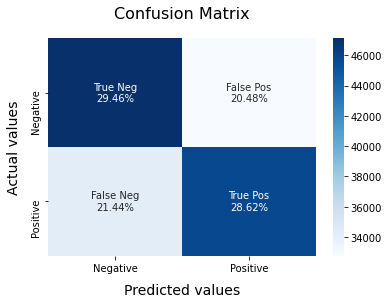

In [ ]:
#model evaluation
%%time
model_Evaluate(xgb_w2v)

#TF-DIF

##Feature Engineering

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.text, y,
                                                    test_size = 0.05, random_state = 0)

In [ ]:
%%time
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000
CPU times: user 1min 5s, sys: 1.02 s, total: 1min 6s
Wall time: 1min 6s


In [ ]:
X_train_tfidf = vectoriser.transform(X_train)
X_test_tfidf  = vectoriser.transform(X_test)

In [ ]:
def model_Evaluate(model):    
  # Predict values for Test dataset
  y_pred = model.predict(X_test_tfidf)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':16}, pad = 20)

## Modeling

### BernoulliNB

In [ ]:
%%time
#testing how fit of the dataset
BNBmodel_tf = BernoulliNB(alpha = 2)
BNBmodel_tf.fit(X_train_tfidf, y_train)
print("----------------------Naive Bayes Regression Scores----------------------")
print('Training set score:', BNBmodel_tf.score(X_train_tfidf, y_train))
print('Tesing set score:', BNBmodel_tf.score(X_test_tfidf, y_test))

----------------------Naive Bayes Regression Scores----------------------
Training set score: 0.818794617628038
Tesing set score: 0.7836
CPU times: user 1.21 s, sys: 3.99 ms, total: 1.22 s
Wall time: 1.22 s


In [ ]:
%%time
#making prediction
predictions_BNBmodel_tf = BNBmodel_tf.predict_proba(X_train_tfidf)

#log loss
logloss_tf_bnb = log_loss(y_train, predictions_BNBmodel_tf)

print ("logloss:  {:.3f}".format(logloss_tf_bnb))

#accuracy score
BNBmodel_tf_score = BNBmodel_tf.score(X_train_tfidf, y_train)

logloss:  0.477
CPU times: user 1.18 s, sys: 3.97 ms, total: 1.18 s
Wall time: 1.18 s


              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39986
           1       0.77      0.80      0.79     40014

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000

CPU times: user 335 ms, sys: 6.99 ms, total: 342 ms
Wall time: 341 ms


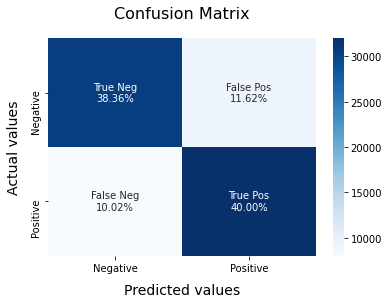

In [ ]:
%%time
model_Evaluate(BNBmodel_tf)

### Logistic regression

In [ ]:
%%time
#testing how fit of the dataset
lr_tf = LogisticRegression()
lr_tf.fit(X_train_tfidf, y_train)
print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr_tf.score(X_train_tfidf, y_train))
print('Tesing set score:', lr_tf.score(X_test_tfidf, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.8343367331162718
Tesing set score: 0.7978
CPU times: user 53.2 s, sys: 1min 22s, total: 2min 15s
Wall time: 39.8 s


In [ ]:
%%time
#making prediction
predictions_lr_tf = lr_tf.predict_proba(X_train_tfidf)

#log loss
logloss_tf_lr = log_loss(y_train, predictions_lr_tf)

print ("logloss:  {:.3f}".format(logloss_tf_lr))

#accuracy score
lr_tf_score = lr_tf.score(X_train_tfidf, y_train)

logloss:  0.392
CPU times: user 679 ms, sys: 3.96 ms, total: 683 ms
Wall time: 681 ms


              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39986
           1       0.79      0.81      0.80     40014

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

CPU times: user 279 ms, sys: 2.01 ms, total: 281 ms
Wall time: 280 ms


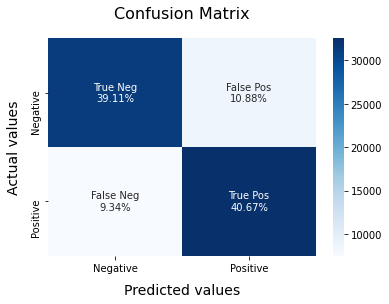

In [ ]:
%%time
model_Evaluate(lr_tf)

### Random Forest

In [ ]:
%%time
#testing how fit of the dataset
rf_tf = RandomForestClassifier(criterion = 'entropy', max_features= 'log2', n_estimators=200, max_samples=0.5, max_depth=5)
rf_tf.fit(X_train_tfidf, y_train)
print("----------------------Random Forest Scores----------------------")
print('Training set score:', rf_tf.score(X_train_tfidf, y_train))
print('Tesing set score:', rf_tf.score(X_test_tfidf, y_test))

----------------------Random Forest Scores----------------------
Training set score: 0.5308562703001778
Tesing set score: 0.530375
CPU times: user 1min 10s, sys: 323 ms, total: 1min 10s
Wall time: 1min 10s


In [ ]:
%%time
#making prediction
predictions_rf_tf = rf_tf.predict_proba(X_train_tfidf)

#log loss
logloss_tf_rf = log_loss(y_train, predictions_rf_tf)

print ("logloss:  {:.3f}".format(logloss_tf_rf))

#accuracy score
rf_tf_score = rf_tf.score(X_train_tfidf, y_train)

logloss:  0.693
CPU times: user 50 s, sys: 122 ms, total: 50.1 s
Wall time: 50.2 s


              precision    recall  f1-score   support

           0       0.69      0.11      0.19     39986
           1       0.52      0.95      0.67     40014

    accuracy                           0.53     80000
   macro avg       0.60      0.53      0.43     80000
weighted avg       0.60      0.53      0.43     80000

CPU times: user 1.58 s, sys: 14 ms, total: 1.59 s
Wall time: 1.59 s


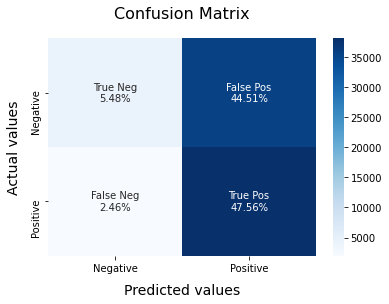

In [ ]:
%%time
model_Evaluate(rf_tf)

### XGBoost

In [ ]:
%%time
#testing how fit of the dataset
xgb_tf = XGBClassifier()
xgb_tf.fit(X_train_tfidf, y_train)
print("----------------------XGBClassifier Scores----------------------")
print('Training set score:', xgb_tf.score(X_train_tfidf, y_train))
print('Tesing set score:', xgb_tf.score(X_test_tfidf, y_test))

----------------------XGBClassifier Scores----------------------
Training set score: 0.6673839916999945
Tesing set score: 0.669175
CPU times: user 5min 12s, sys: 177 ms, total: 5min 12s
Wall time: 5min 12s


In [ ]:
%%time
#making prediction
predictions_xgb_tf = xgb_tf.predict_proba(X_train_tfidf)

#log loss
logloss_tf_xgb = log_loss(y_train, predictions_xgb_tf)

print ("logloss: {:.3f}".format(logloss_tf_xgb))

#accuracy score
xgb_tf_score = xgb_tf.score(X_train_tfidf, y_train)

logloss: 0.614
CPU times: user 15.4 s, sys: 135 ms, total: 15.6 s
Wall time: 15.5 s


              precision    recall  f1-score   support

           0       0.80      0.45      0.58     39986
           1       0.62      0.89      0.73     40014

    accuracy                           0.67     80000
   macro avg       0.71      0.67      0.65     80000
weighted avg       0.71      0.67      0.65     80000

CPU times: user 809 ms, sys: 4.03 ms, total: 813 ms
Wall time: 812 ms


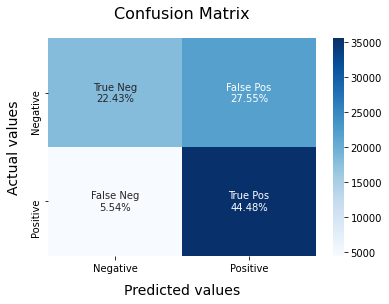

In [ ]:
%%time
model_Evaluate(xgb_tf)

#Evaluation Model

In [ ]:
#create dataframe to store the log loss
eva_log_loss = pd.DataFrame([['BernoulliNB',logloss_bow_bnb,logloss_w2v_bnb, logloss_tf_bnb],
                          ['Logistic Regression', logloss_bow_lr, logloss_w2v_lr, logloss_tf_lr],
                          ['Random Forest', logloss_bow_rf,logloss_w2v_rf, logloss_tf_rf],                        
                          ['XGBoost', logloss_bow_xgb, logloss_w2v_xgb,logloss_tf_xgb]],
                          columns = ["Classifier_Model",'Bag of Word', 'Word to Vector', 'TF-DIF']
                          )
eva_log_loss

,Classifier_Model,Bag of Word,Word to Vector,TF-DIF
0,BernoulliNB,0.683355,0.716371,0.477183
1,Logistic Regression,0.583850,0.680066,0.391607
2,Random Forest,0.642566,0.684908,0.693004
3,XGBoost,0.582046,0.672825,0.613735


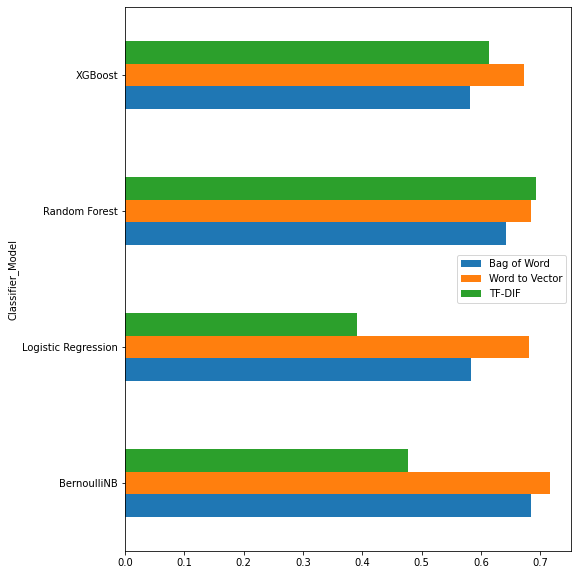

In [ ]:
eva_log_loss.set_index('Classifier_Model').plot.barh(figsize=(8,10))

In [ ]:
#create ataframe to store the accuracy score
eva_accuracy = pd.DataFrame([['BernoulliNB',BNBmodel_bow_score, BNBmodel_w2v_score, BNBmodel_tf_score],
                          ['Logistic Regression', lr_bow_score, lr_w2v_score, lr_tf_score],
                          ['Random Forest', rf_bow_score, rf_w2v_score, rf_tf_score],                        
                          ['XGBoost', xgb_bow_score, xgb_w2v_score, xgb_tf_score]],
                          columns = ["Classifier_Model",'Bag of Word', 'Word to Vector', 'TF-DIF']
                          )
eva_accuracy

,Classifier_Model,Bag of Word,Word to Vector,TF-DIF
0,BernoulliNB,0.619463,0.526596,0.818795
1,Logistic Regression,0.690356,0.568417,0.834337
2,Random Forest,0.671200,0.570669,0.530856
3,XGBoost,0.689744,0.582642,0.667384


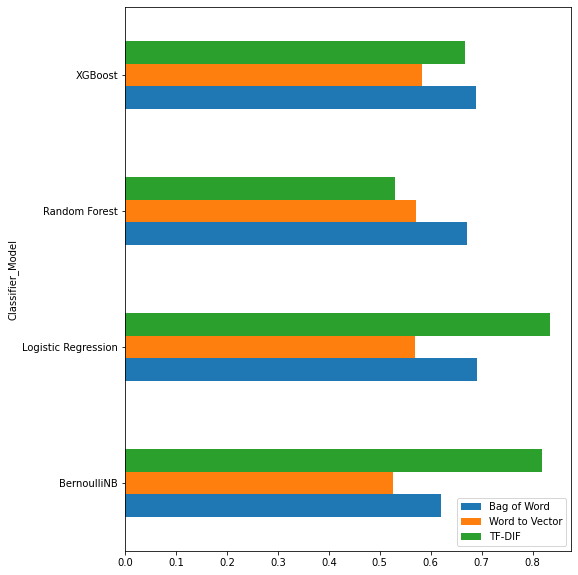

In [ ]:
eva_accuracy.set_index('Classifier_Model').plot.barh(figsize=(8,10))


#Tunning Parameter

##Logistic regression

In [ ]:
# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('lr', lr_model)])

In [ ]:
param_grid = {'lr__C': [0.01, 0.1, 1.0, 10.0, 100.0], 
              'lr__penalty': ['l1', 'l2','elasticnet', 'none'],
              'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

In [ ]:
# Initialize Grid Search Model
model_lr = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1,
                                 verbose=10, iid=True, refit=True, cv=2)


In [ ]:
%%time 
# Fit Grid Search Model
# I use the full data
model_lr.fit(X_test_tfidf, y_test)  

Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 32.0min finished


CPU times: user 3.89 s, sys: 5.95 s, total: 9.84 s
Wall time: 31min 59s


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                                  

In [ ]:
print("Best score: %0.3f" % model_lr.best_score_)
print("Best parameters set:")
best_parameters = model_lr.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.756
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	lr__solver: 'newton-cg'


In [ ]:
%%time
#making prediction
predictions_model_lr = model_lr.predict_proba(X_train_tfidf)

#log loss
logloss_model_lr = log_loss(y_train, predictions_model_lr)

print ("logloss:  {:.3f}".format(logloss_model_lr))

logloss:  0.498
CPU times: user 497 ms, sys: 94 ms, total: 591 ms
Wall time: 490 ms


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     39986
           1       0.85      0.88      0.87     40014

    accuracy                           0.86     80000
   macro avg       0.86      0.86      0.86     80000
weighted avg       0.86      0.86      0.86     80000



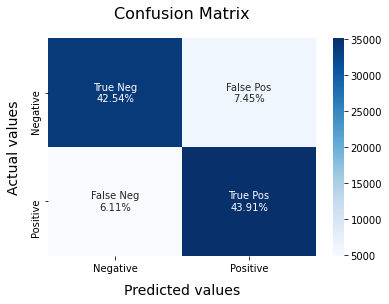

In [ ]:
model_Evaluate(model_lr)

##BernoulliNB

In [ ]:
# using BernoulliNB 
nb_model = BernoulliNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 10, 20, 50],
              'nb__binarize': [0,1,2,3,4,5,10,20,30,50,80,90,100]}

# Initialize Grid Search Model
model_bnb = GridSearchCV(estimator=clf, param_grid=param_grid,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)


In [ ]:
%%time 
# Fit Grid Search Model
model_bnb.fit(X_test_tfidf, y_test) 

Fitting 2 folds for each of 143 candidates, totalling 286 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

CPU times: user 1.56 s, sys: 354 ms, total: 1.92 s
Wall time: 11.3 s


[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:   11.1s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('nb',
                                        BernoulliNB(alpha=1.0, binarize=0.0,
                                                    class_prior=None,
                                                    fit_prior=True))],
                                verbose=False),
             iid=True, n_jobs=-1,
             param_grid={'nb__alpha': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 10, 20,
                                       50],
                         'nb__binarize': [0, 1, 2, 3, 4, 5, 10, 20, 30, 50, 80,
                                          90, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [ ]:
print("Best score: %0.3f" % model_bnb.best_score_)
print("Best parameters set:")
best_parameters = model_bnb.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.753
Best parameters set:
	nb__alpha: 4
	nb__binarize: 0


In [ ]:
%%time
#making prediction
predictions_model_bnb = model_bnb.predict_proba(X_train_tfidf)

#log loss
logloss_model_bnb = log_loss(y_train, predictions_model_bnb)

print ("logloss:  {:.3f}".format(logloss_model_bnb))

logloss:  0.541
CPU times: user 839 ms, sys: 35 ms, total: 874 ms
Wall time: 875 ms


              precision    recall  f1-score   support

           0       0.87      0.83      0.85     39986
           1       0.83      0.88      0.86     40014

    accuracy                           0.85     80000
   macro avg       0.85      0.85      0.85     80000
weighted avg       0.85      0.85      0.85     80000



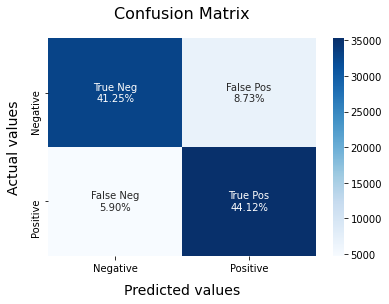

In [ ]:
model_Evaluate(model_bnb)